This is a Poisson equation with Dirichlet and Robin initial conditions solved with a PINN model using the DeepXDE library.

<br>

\begin{equation}
Δu = 2 \hspace{1cm} x∈[−1,1]
\end{equation}

<br>

\begin{equation}
\frac{\partial u}{\partial x} = u \hspace{1cm} \textrm{for } x = 1
\end{equation}

<br>

\begin{equation}
u'(-1) = 0
\end{equation}

Test losses after 6000 epochs are approximately:

*In accordance to y output:* **6.11e-06**

*In accordance to initial conditions:* **8.19e-10**, **3.50e-09**

*In accordance to the known solution:* **5.27e-05**

In [ ]:
# Importing libraries
  
!pip install deepxde
import deepxde as dde
import numpy as np

Using backend: tensorflow.compat.v1



Instructions for updating:
non-resource variables are not supported in the long term



In [ ]:
# Define computational geometry

geom = dde.geometry.Interval(-1,1)

In [ ]:
# Define the differential equation

def ode(x,y):
  du_xx = dde.grad.hessian(y,x)
  return du_xx - 2

In [ ]:
# Define initial conditions

def ic_dirichlet (x,_):
  return np.isclose(x[0], -1)

def ic_robin (x,_):
  return np.isclose(x[0],1)

ic1 = dde.DirichletBC(geom, lambda x: 0, ic_dirichlet)
ic2 = dde.RobinBC(geom, lambda x, y: y, ic_robin)

In [ ]:
# Define known solution

def sol(x):
  return (x+1)**2

In [ ]:
# Accumulate all the data for the model

data = dde.data.PDE(geom, ode, [ic1,ic2], num_domain=500, num_boundary = 10, solution = sol, num_test = 100)

/usr/local/lib/python3.7/dist-packages/skopt/sampler/sobol.py:250: UserWarning: The balance properties of Sobol' points require n to be a power of 2. 0 points have been previously generated, then: n=0+502=502. 
  total_n_samples))


In [ ]:
# Create the neural network

layer_size = [1] + [60]*2 + [1]
activation = "tanh"
initializer = "Glorot uniform"

net = dde.nn.FNN(layer_size, activation, initializer)

In [ ]:
# Build and train the model

model = dde.Model(data,net)
model.compile("adam", lr=0.01, metrics = ["l2 relative error"])

losshistory, train_state = model.train(epochs = 6000)

/usr/local/lib/python3.7/dist-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:110: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  kernel_constraint=self.kernel_constraint,
/usr/local/lib/python3.7/dist-packages/keras/legacy_tf_layers/core.py:261: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  return layer.apply(inputs)


Compiling model...
Building feed-forward neural network...
'build' took 0.126146 s

'compile' took 0.971156 s

Initializing variables...
Training model...

Step      Train loss                        Test loss                         Test metric   
0         [4.00e+00, 4.72e-02, 9.34e-05]    [4.00e+00, 4.72e-02, 9.34e-05]    [9.54e-01]    
1000      [5.54e-05, 4.00e-07, 2.11e-07]    [4.17e-05, 4.00e-07, 2.11e-07]    [1.64e-04]    
2000      [7.43e-03, 9.12e-03, 2.32e-02]    [7.00e-03, 9.12e-03, 2.32e-02]    [4.14e-02]    
3000      [1.59e-03, 1.02e-04, 1.45e-03]    [1.47e-03, 1.02e-04, 1.45e-03]    [4.20e-03]    
4000      [3.92e-06, 1.87e-09, 4.46e-09]    [2.70e-06, 1.87e-09, 4.46e-09]    [8.45e-05]    
5000      [5.11e-06, 9.70e-11, 2.27e-11]    [3.82e-06, 9.70e-11, 2.27e-11]    [6.68e-05]    
6000      [7.83e-06, 8.19e-10, 3.50e-09]    [6.11e-06, 8.19e-10, 3.50e-09]    [5.27e-05]    

Best model at step 4000:
  train loss: 3.93e-06
  test loss: 2.70e-06
  test metric: [8.45e-05]

't

Saving loss history to /content/loss.dat ...
Saving training data to /content/train.dat ...
Saving test data to /content/test.dat ...


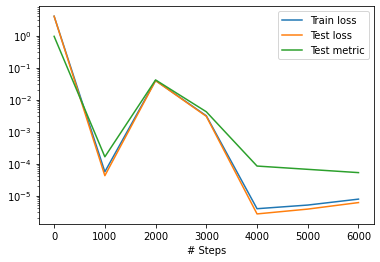

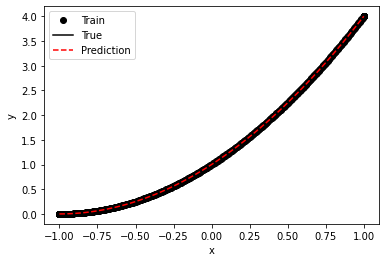

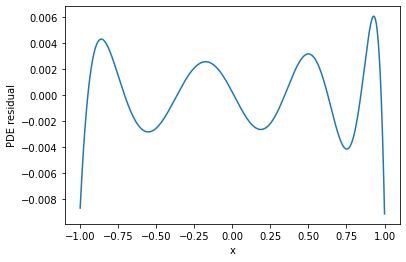

In [ ]:
# Generating plots of the results.

import matplotlib.pyplot as plt

dde.saveplot(losshistory, train_state, issave=True, isplot=True)
x = geom.uniform_points(1000, True)
y = model.predict(x, operator=ode)

plt.figure()
plt.plot(x, y)
plt.xlabel("x")
plt.ylabel("PDE residual")
plt.show()